# Laboratorio 8: Procesamiento EMG
## Parte 1: características de señal completa

## Obtención de la señal EMG

In [440]:
#Importar librerías
from numpy import linspace, max, min, average, std, sum, sqrt, where, argmax
from scipy.integrate import cumtrapz
from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np

# Archivo que contiene los datos
archivo = "C:\\Users\\romin\\ISB2024\\Nicole-04-12_10-15-28.txt"

# Leer los datos del archivo y omitir las primeras 7 líneas
datos = np.loadtxt(archivo, skiprows=7)

# Extraer la columna de interés (columna 6)
senal = datos[:, 5]

# Número de muestra
num_muestra = np.arange(len(senal))
# Conversión a V de la señal (según fórmula del Sensor user manual, disponible en: https://www.bitalino.com/storage/uploads/media/electromyography-emg-user-manual.pdf)
senalV = (((senal/1024)-1/2)*3.3)/1009
#Frecuencia de sampling usada en Bitalino
fs = 1000 
senalmV = senalV*fs # en mV
# Mostrar la señal
t = num_muestra/fs
#plt.plot(t, senalmV)
#plt.xlabel('Tiempo')
#plt.ylabel('EMG (mV)')
#plt.title('EMG')
#plt.grid(True)
#plt.show()

## Filtrado (Wavelet)
#### Basado en “Discrete wavelet transform based processing of embroidered textile-electrode electromyography signal acquired with load and pressure effect - Bulcha Belay Etana, Ahmed Ali Dawud, Benny Malengier, Wojciech Sitek, Wendimu Fanta Gemechu, Janarthanan Krishnamoorthy, Lieva Van Langenhove, 2024”. Consultado: el 17 de mayo de 2024. [En línea]. Disponible en: https://journals.sagepub.com/doi/10.1177/15280837241232449

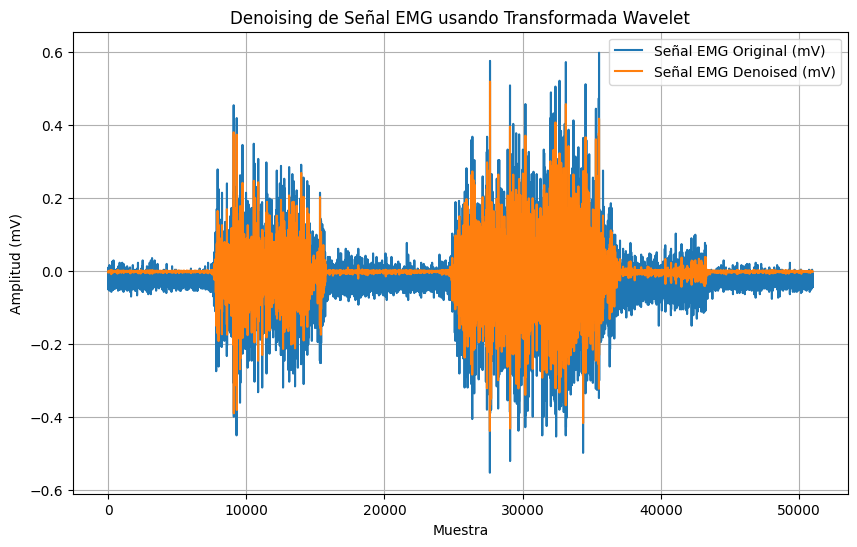

In [441]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Definir parámetros de la transformada wavelet
wavelet = 'sym5'  # Wavelet Symlet con 5 momentos de desaparición
level = 4  # Nivel de descomposición
mode = 'symmetric'  # Modo de extensión de señal

# Realizar la descomposición wavelet
coefficients = pywt.wavedec(senalmV, wavelet, level=level, mode=mode)

# Método de umbralización y valor de umbral
threshold_method = 'soft'  # Método de umbralización soft
threshold_value = 0.1  # Ajustar el valor del umbral según su señal y nivel de ruido

# Aplicar umbralización a los coeficientes de la wavelet
coefficients_thresh = [pywt.threshold(c, threshold_value, mode=threshold_method) for c in coefficients]

# Reconstruir la señal denoised
emg_denoised = pywt.waverec(coefficients_thresh, wavelet, mode=mode)

# Graficar la señal EMG original y denoised
plt.figure(figsize=(10, 6))
plt.plot(senalmV, label='Señal EMG Original (mV)')
plt.plot(emg_denoised, label='Señal EMG Denoised (mV)')
plt.xlabel('Muestra')
plt.ylabel('Amplitud (mV)')
plt.title('Denoising de Señal EMG usando Transformada Wavelet')
plt.legend()
plt.grid(True)
plt.show()

In [442]:
#Sin segmentación para procesar la señal completa
segmented_emg = emg_denoised


## Extracción de características

In [443]:
#Detección de activación muscular
import biosignalsnotebooks as bsnb
burst_begin, burst_end = bsnb.detect_emg_activations(segmented_emg, fs, smooth_level=20, threshold_level=0.5, time_units=True, plot_result=True)[:2]

#Number of muscular activations: 2

In [444]:
# Bursts Duration
bursts_time = burst_end - burst_begin
print(burst_end)
# Parameter extraction
max_time = max(bursts_time)
min_time = min(bursts_time)
avg_time = average(bursts_time)
std_time = std(bursts_time)
print(f"Maximum time: {max_time}")
print(f"Minimum time: {min_time}")
print(f"Average time: {avg_time}")
print(f"Standard Deviation time: {std_time}")

[15.82131025 36.95272462 43.20984732]
Maximum time: 11.99823527796843
Minimum time: 0.1350026473183661
Average time: 6.762465941105337
Standard Deviation time: 4.942110289106193


In [445]:
# Max
max_sample_value = max(segmented_emg)

# Min
min_sample_value = min(segmented_emg)

# Average and Standard Deviation
avg_sample_value = average(segmented_emg)
std_sample_value = std(segmented_emg)

print(f"Maximum EMG: {max_sample_value}")
print(f"Minimum EMG: {min_sample_value}")
print(f"Average EMG: {avg_sample_value}")
print(f"Standard Deviation EMG: {std_sample_value}")

Maximum EMG: 0.5181613974360016
Minimum EMG: -0.4382966900396984
Average EMG: -0.006030542701886204
Standard Deviation EMG: 0.0479636435787714


### Análisis de la señal EMG

In [446]:
bsnb.plot_emg_graphical_statistical(t, segmented_emg, max_sample_value, min_sample_value, avg_sample_value, std_sample_value)

## Características usadas en los artículos:
#### “Discrete wavelet transform based processing of embroidered textile-electrode electromyography signal acquired with load and pressure effect - Bulcha Belay Etana, Ahmed Ali Dawud, Benny Malengier, Wojciech Sitek, Wendimu Fanta Gemechu, Janarthanan Krishnamoorthy, Lieva Van Langenhove, 2024”. Consultado: el 17 de mayo de 2024. [En línea]. Disponible en: https://journals.sagepub.com/doi/10.1177/15280837241232449
#### H. Jebelli y S. Lee, «Feasibility of Wearable Electromyography (EMG) to Assess Construction Workers’ Muscle Fatigue: Proceedings of the 35th CIB W78 2018 Conference: IT in Design, Construction, and Management», 2019, pp. 181-187. doi: 10.1007/978-3-030-00220-6_22. Consultado: el 18 de mayo de 2024. [En línea]. Disponible en: https://www.researchgate.net/figure/The-values-of-MAV-RMS-MEF-and-MDF-for-bicep-muscle_fig3_328141269

#### RMS

In [447]:
rms_value = np.sqrt(np.mean(np.square(segmented_emg)))
print(f"El valor RMS de la señal EMG es: {rms_value}")

# Area under the curve
area = cumtrapz(segmented_emg)
bsnb.plot_emg_rms_area(t, segmented_emg, rms_value, area)

El valor RMS de la señal EMG es: 0.04834127171093756


#### MAV

In [448]:
mav_value = np.mean(np.abs(segmented_emg))
print(f"El valor MAV de la señal EMG es: {mav_value}")

El valor MAV de la señal EMG es: 0.022821795837418172


#### Frecuencia Mediana (MDF) y frecuencia media (MNF)

In [449]:
# Calcular la FFT de la señal
N = len(segmented_emg)
freqs = np.fft.rfftfreq(N, 1/fs)
fft_magnitude = np.abs(np.fft.rfft(segmented_emg))

# Calcular el espectro de potencia
power_spectrum = fft_magnitude**2

# Calcular la potencia acumulada
cumulative_power = np.cumsum(power_spectrum)

# Encontrar la frecuencia mediana
total_power = cumulative_power[-1]
median_freq_index = np.where(cumulative_power >= total_power / 2)[0][0]
MDF = freqs[median_freq_index]
print(f"Frecuencia mediana (MDF): {MDF} Hz")

# Calcular la frecuencia media (MNF)
MNF = np.sum(freqs * power_spectrum) / np.sum(power_spectrum)
print(f"Frecuencia media (MNF): {MNF} Hz")

Frecuencia mediana (MDF): 51.10204721938975 Hz
Frecuencia media (MNF): 58.054472681504066 Hz


## Características usadas en el artículo:
#### J. M. L. Villagómez, R. I. M. Chávez, J. M. L. Hernández and C. Rodriguez-Donate, "Hand movement classification by time domain feature extraction in EMG signals," 2023 IEEE International Autumn Meeting on Power, Electronics and Computing (ROPEC), Ixtapa, Mexico, 2023, pp. 1-6, doi: 10.1109/ROPEC58757.2023.10409406.

#### Kurtosis

In [450]:
from scipy.stats import kurtosis

# Calcular la curtosis de la señal EMG
emg_kurtosis = kurtosis(segmented_emg)
print(f"Curtosis de la señal EMG: {emg_kurtosis}")

Curtosis de la señal EMG: 13.129755217849077


#### Skewness

In [451]:
from scipy.stats import skew

# Calcular la asimetría de la señal EMG
emg_skewness = skew(segmented_emg)
print(f"Asimetría (skewness) de la señal EMG: {emg_skewness}")

Asimetría (skewness) de la señal EMG: -0.042276882554291476


#### También se usó RMS y MAV

### Otras características (mencionadas en Jaramillo, Andres & Benalcázar, Marco & Mena-Maldonado, Elisa. (2020). Real-Time Hand Gesture Recognition Using Surface Electromyography and Machine Learning: A Systematic Literature Review. Sensors. 20. 2467. 10.3390/s20092467.)

#### iEMG

In [452]:
iemg_value = np.sum(np.abs(segmented_emg))
print(f"El valor iEMG de la señal EMG es: {iemg_value}")

El valor iEMG de la señal EMG es: 1163.820300524977


#### Longitud de la Forma de Onda (WL)

In [453]:
WL = len(segmented_emg)
print("Longitud de la forma de onda (WL):", WL)

Longitud de la forma de onda (WL): 50996


#### Cruces por Cero (ZC)

In [454]:
ZC = np.sum(np.diff(np.sign(segmented_emg)) != 0)
print("Cruces por cero (ZC):", ZC)

Cruces por cero (ZC): 3418


#### Cambios en el Signo de la Pendiente (SSC)

In [455]:
SSC = np.sum(np.diff(np.sign(np.diff(segmented_emg))) != 0)
print("Cambios en el signo de la pendiente (SSC):", SSC)

Cambios en el signo de la pendiente (SSC): 5178


#### Total power

In [456]:
# Signal Power Spectrum
f, P = welch(segmented_emg, fs=fs, window='hanning', noverlap=0, nfft=int(256.))

# Total Power and Median Frequency (Frequency that divides the spectrum into two regions with equal power)
area_freq = cumtrapz(P, f, initial=0)
total_power = area_freq[-1]
median_freq = f[where(area_freq >= total_power / 2)[0][0]]
f_max = f[argmax(P)]
print("Total power:", total_power)
bsnb.plot_emg_spect_freq(f, P, f_max, median_freq)

Total power: 0.00224677723692478
